<a href="https://colab.research.google.com/github/mutturajiu/BA05-TRIM02-Module-04-Text-Analytics-/blob/master/Sentiment_Analysis_With_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import pickle
import sys
import os
import io
import re
from sys import path
import numpy as np
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
from string import punctuation, digits
from IPython.core.display import display, HTML
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer

In [0]:
pwd()

'/content'

In [0]:
#Amazon Data
input_file = "../content/sample_data/amazon_cells_labelled.txt"
amazon = pd.read_csv(input_file,delimiter='\t',header=None)
amazon.columns = ['Sentence','Class']
#Yelp Data
input_file = "../content/sample_data/yelp_labelled.txt"
yelp = pd.read_csv(input_file,delimiter='\t',header=None)
yelp.columns = ['Sentence','Class']
#Imdb Data
input_file = "../content/sample_data/imdb_labelled.txt"
imdb = pd.read_csv(input_file,delimiter='\t',header=None)
imdb.columns = ['Sentence','Class']
#combine all data sets
data = pd.DataFrame()
data = pd.concat([amazon, yelp, imdb])
data['index'] = data.index
data

,Sentence,Class,index
0,So there is no way for me to plug it in here i...,0,0
1,"Good case, Excellent value.",1,1
2,Great for the jawbone.,1,2
3,Tied to charger for conversations lasting more...,0,3
4,The mic is great.,1,4
5,I have to jiggle the plug to get it to line up...,0,5
6,If you have several dozen or several hundred c...,0,6
7,If you are Razr owner...you must have this!,1,7
8,"Needless to say, I wasted my money.",0,8
9,What a waste of money and time!.,0,9


   Class  COUNT
0      0    846
1      1    827


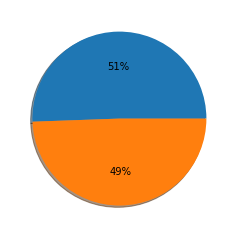

In [0]:
#Total Count of Each Category
pd.set_option('display.width', 4000)
pd.set_option('display.max_rows', 1000)
distOfDetails = data.groupby(by='Class', as_index=False).agg({'index': pd.Series.nunique}).sort_values(by='index', ascending=False)
distOfDetails.columns =['Class', 'COUNT']
print(distOfDetails)
#Distribution of All Categories
plt.pie(distOfDetails['COUNT'],autopct='%1.0f%%',shadow=True, startangle=360)
plt.show()

In [0]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
#Text Preprocessing
columns = ['index','Class', 'Sentence']
df_ = pd.DataFrame(columns=columns)
#lower string
data['Sentence'] = data['Sentence'].str.lower()
#remove email adress
data['Sentence'] = data['Sentence'].replace('[a-zA-Z0-9-_.]+@[a-zA-Z0-9-_.]+', '', regex=True)
#remove IP address
data['Sentence'] = data['Sentence'].replace('((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.|$)){4}', '', regex=True)
#remove punctaitions and special chracters
data['Sentence'] = data['Sentence'].str.replace('[^\w\s]','')
#remove numbers
data['Sentence'] = data['Sentence'].replace('\d', '', regex=True)
#remove stop words
for index, row in data.iterrows():
    word_tokens = word_tokenize(row['Sentence'])
    filtered_sentence = [w for w in word_tokens if not w in stopwords.words('english')]
    df_ = df_.append({"index": row['index'], "Class":  row['Class'],"Sentence": " ".join(filtered_sentence[0:])}, ignore_index=True)
data = df_

In [0]:
X_train, X_test, y_train, y_test = train_test_split(data['Sentence'].values.astype('U'),data['Class'].values.astype('int32'), test_size=0.10, random_state=0)
classes  = data['Class'].unique()

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
#grid search result
vectorizer = TfidfVectorizer(analyzer='word',ngram_range=(1,2), max_features=50000,max_df=0.5,use_idf=True, norm='l2') 
counts = vectorizer.fit_transform(X_train)
vocab = vectorizer.vocabulary_
classifier = SGDClassifier(alpha=1e-05,max_iter=50,penalty='elasticnet')
targets = y_train
classifier = classifier.fit(counts, targets)
example_counts = vectorizer.transform(X_test)
predictions = classifier.predict(example_counts)

In [0]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
#Model Evaluation
acc = accuracy_score(y_test, predictions, normalize=True)
hit = precision_score(y_test, predictions, average=None,labels=classes)
capture = recall_score(y_test, predictions, average=None,labels=classes)
print('Model Accuracy:%.2f'%acc)
print(classification_report(y_test, predictions))

Model Accuracy:0.80
              precision    recall  f1-score   support

           0       0.79      0.82      0.80       139
           1       0.81      0.77      0.79       136

    accuracy                           0.80       275
   macro avg       0.80      0.80      0.80       275
weighted avg       0.80      0.80      0.80       275



In [0]:
#source: https://www.kaggle.com/grfiv4/plot-a-confusion-matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        print()
    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.figure(figsize=(150,100))

,Category,Index
0,0,1
1,1,2


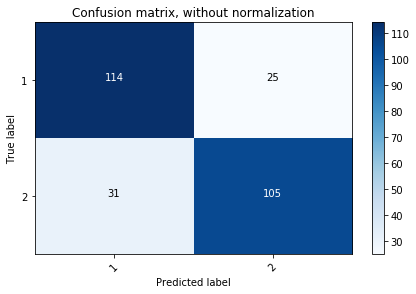

<Figure size 10800x7200 with 0 Axes>

In [0]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, predictions,classes)
np.set_printoptions(precision=2)
class_names = range(1,classes.size+1)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,title='Confusion matrix, without normalization')
classInfo = pd.DataFrame(data=[])
for i in range(0,classes.size):
    classInfo = classInfo.append([[classes[i],i+1]],ignore_index=True)
classInfo.columns=['Category','Index']
classInfo

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
#tokenizer to remove unwanted elements from out data like symbols and numbers
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(lowercase=True,stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)
text_counts= cv.fit_transform(data['Sentence'])

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    text_counts, data['Class'], test_size=0.3, random_state=1)

In [0]:
from sklearn.naive_bayes import MultinomialNB
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Generation Using Multinomial Naive Bayes
clf = MultinomialNB().fit(X_train, y_train)
predicted= clf.predict(X_test)
print("MultinomialNB Accuracy:",metrics.accuracy_score(y_test, predicted))

ValueError: ignored

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    text_counts, data['Class'], test_size=0.3, random_state=1)

In [0]:
from sklearn import neighbors, linear_model
knn = neighbors.KNeighborsClassifier(n_neighbors = 5)
knn_model_1 = knn.fit(X_train, y_train)
print('k-NN accuracy for test set: %f' % knn_model_1.score(X_test, y_test))

https://dzone.com/articles/simple-sentiment-analysis-with-nlp

https://www.technavio.com/industries/auto-components